In [1]:

import os
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM

In [3]:
input_shape=(150,150,3)
effnet = EfficientNetB0(weights=None,include_top=False,input_shape=input_shape)
effnets=effnet.input_shape#(150,150,3)
print(effnets)
Res_model = effnet.output
print(Res_model.shape)  


(None, 150, 150, 3)
(None, 5, 5, 1280)


In [4]:
#data preprocessing
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths to your data folders
fake_videos_path = r"C:/Users/aruna/OneDrive/Desktop/smal_data/fake"
real_videos_path = r"C:/Users/aruna/OneDrive/Desktop/smal_data/real"

# Function to load and preprocess frames
def load_frames(video_folder):
    frames = []
    labels = []
    for video_name in os.listdir(video_folder):
        video_path = os.path.join(video_folder, video_name)
        for frame_name in os.listdir(video_path):
            frame_path = os.path.join(video_path, frame_name)
            # Load and preprocess frame
            frame = load_img(frame_path, target_size=(150, 150))
            frame_array = img_to_array(frame) / 255.0
            frames.append(frame_array)
            # Assign label based on parent folder
            labels.append(1 if "fake" in video_folder else 0)  # Assuming "fake" is in fake_videos_path
    return np.array(frames), np.array(labels)

# Load and preprocess frames from fake videos
fake_frames, fake_labels = load_frames(fake_videos_path)

# Load and preprocess frames from real videos
real_frames, real_labels = load_frames(real_videos_path)

# Concatenate frames and labels
all_frames = np.concatenate((fake_frames, real_frames), axis=0)
all_labels = np.concatenate((fake_labels, real_labels), axis=0)

# Shuffle the data
shuffle_indices = np.random.permutation(len(all_frames))
all_frames = all_frames[shuffle_indices]
all_labels = all_labels[shuffle_indices]

# Perform train/test split if needed

# Example: train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_frames, all_labels, test_size=0.2, random_state=42)

# Now you can use X_train, X_test, y_train, y_test for training/testing your model


In [5]:
X_train.shape

(7200, 150, 150, 3)

In [6]:
# Reshape y_train to have the correct shape
y_train = y_train.reshape(-1, 1)

# Verify the shape
print("y_train shape:", y_train.shape)


y_train shape: (7200, 1)


In [7]:
#final model arch_ab
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Flatten

# Define EfficientNet model for feature extraction
effnet = EfficientNetB0(weights=None, include_top=False, input_shape=input_shape)

# Global average pooling on EfficientNet output
effnet_output = effnet.output
global_avg_pooling = GlobalAveragePooling2D()(effnet_output)

# Add a Flatten layer to reshape the data
flattened_output = Flatten()(global_avg_pooling)
sequence_input=(150,150)
# Define LSTM model
sequence_input = Input(shape=sequence_input, name='sequence_input')
lstm_model = LSTM(32)(sequence_input)

# Concatenate features from EfficientNet and LSTM
concatenated_features = Concatenate(axis=1)([flattened_output, lstm_model])

# Dense layers for classification
dense_1 = Dense(512, activation='relu')(concatenated_features)
dropout = Dropout(rate=0.5)(dense_1)
output = Dense(32, activation='softmax')(dropout)

# Define combined model
combined_model = Model(inputs=[effnet.input, sequence_input], outputs=output)

# Print model summary
combined_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 150, 150,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 75, 75,    │         64 │ block1a_project_

 Total params: 4,761,667 (18.16 MB)

 Trainable params: 4,719,644 (18.00 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [8]:
#sequnce data preparation
from skimage.color import rgb2gray

def load_frames(video_folder):
    frames = []
    labels = []
    for video_name in os.listdir(video_folder):
        video_path = os.path.join(video_folder, video_name)
        for frame_name in os.listdir(video_path):
            frame_path = os.path.join(video_path, frame_name)
            # Load frame and convert to grayscale
            frame = load_img(frame_path, target_size=(150, 150))
            frame_array = img_to_array(frame)
            frame_array_gray = rgb2gray(frame_array)
            frames.append(frame_array_gray)
            # Assign label based on parent folder
            labels.append(1 if "fake" in video_folder else 0)
    return np.array(frames), np.array(labels)

# Load and preprocess frames from fake videos
fake_frames, fake_labels = load_frames(fake_videos_path)

# Load and preprocess frames from real videos
real_frames, real_labels = load_frames(real_videos_path)

# Concatenate frames and labels
all_frames = np.concatenate((fake_frames, real_frames), axis=0)
all_labels = np.concatenate((fake_labels, real_labels), axis=0)

# Shuffle the data
shuffle_indices = np.random.permutation(len(all_frames))
all_frames = all_frames[shuffle_indices]
all_labels = all_labels[shuffle_indices]

# Perform train/test split if needed

# Example: train-test split
from sklearn.model_selection import train_test_split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(all_frames, all_labels, test_size=0.2, random_state=42)


In [9]:
X_train_seq.shape

(7200, 150, 150)

In [11]:
# Compile the combined model
combined_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the combined model with both inputs
history=combined_model.fit([X_train, X_train_seq], y_train, batch_size=32, epochs=15, validation_data=([X_test, X_test_seq], y_test))




Epoch 1/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 650s 3s/step - accuracy: 0.9624 - loss: 0.1251 - val_accuracy: 0.4961 - val_loss: 2.6673
Epoch 2/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 689s 3s/step - accuracy: 0.9919 - loss: 0.0278 - val_accuracy: 0.6989 - val_loss: 2.4006
Epoch 3/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 647s 3s/step - accuracy: 0.9909 - loss: 0.0334 - val_accuracy: 0.9594 - val_loss: 0.1784
Epoch 4/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 669s 3s/step - accuracy: 0.9848 - loss: 0.0652 - val_accuracy: 0.8594 - val_loss: 0.9177
Epoch 5/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 860s 4s/step - accuracy: 0.9973 - loss: 0.0103 - val_accuracy: 0.9994 - val_loss: 0.0069
Epoch 6/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.9988 - loss: 0.0058 - val_accuracy: 0.9878 - val_loss: 0.0528
Epoch 7/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 616s 3s/step - accuracy: 0.9999 - loss: 4.1367e-04 - val_accuracy: 1.0000 - val_loss: 7.8978e-04
Epoch 8/15
225/225 ━━━━━━━━━━━━━━━━━━━━ 622s 3s/step - accuracy: 0.9963 - loss: 0.0110 - 

In [ ]:
# Evaluate the trained model on the test set
test_loss, test_accuracy = combined_model.evaluate([X_test,X_test_seq], y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 444ms/step - accuracy: 0.9998 - loss: 3.8267e-04
Test Loss: 0.0011062215780839324
Test Accuracy: 0.9994444251060486


In [ ]:
# Save the model to a HDF5 file
combined_model.save('model.h5')

print("Model saved as model.h5")

Model saved as model.h5


Confusion Matrix:

57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 484ms/step


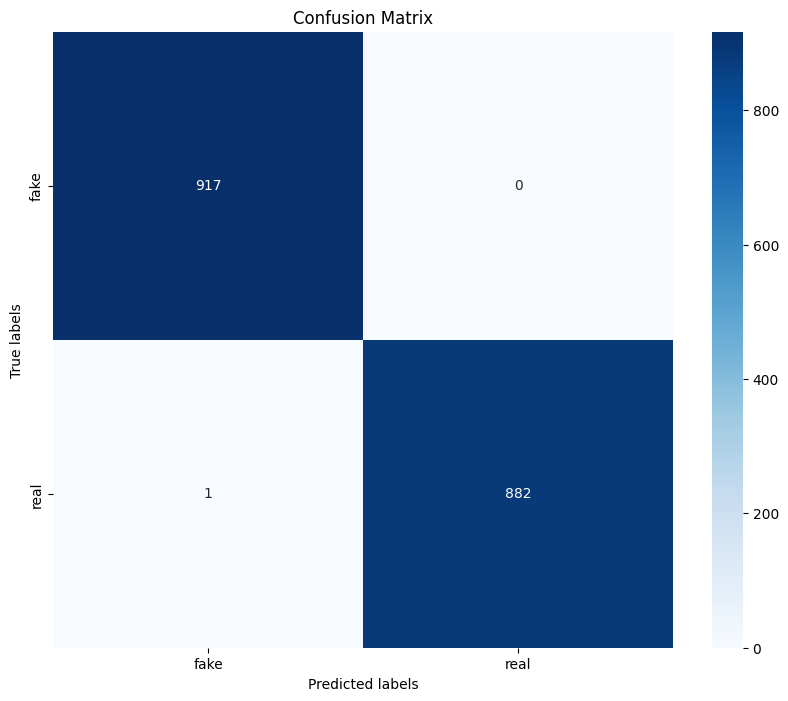

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions on test set
y_pred = combined_model.predict([X_test, X_test_seq])
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
classes=["fake","real"]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()




Classification Report:

In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00       917
        real       1.00      1.00      1.00       883

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



ROC AND AUC Graphs:

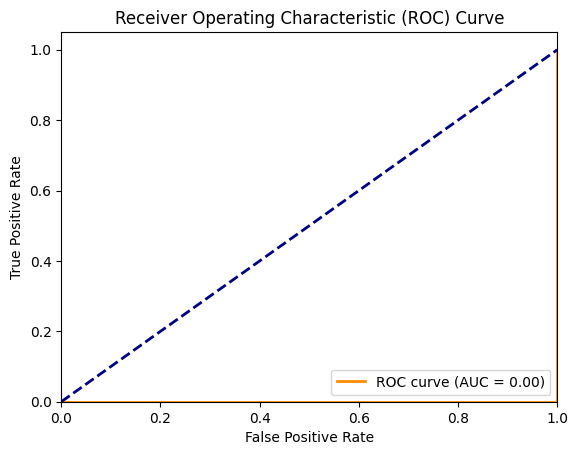

In [ ]:
# Calculate ROC curve and AUC
from sklearn.metrics import roc_curve, auc
y_prob_positive = y_pred[:, 0] 
fpr, tpr, thresholds = roc_curve(y_test, y_prob_positive)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

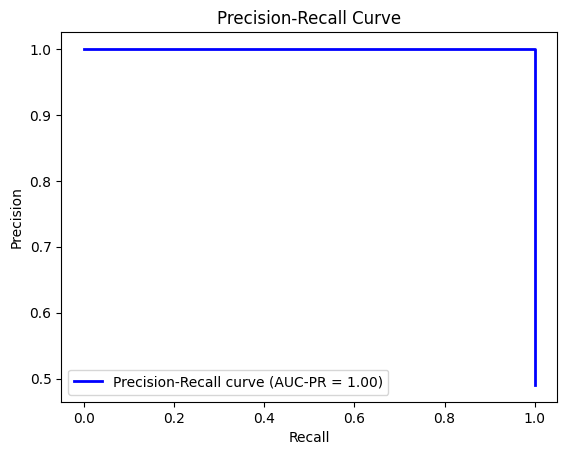

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming you have trained your binary classification model and obtained predictions on the test set
# Get predicted probabilities for the positive class (class 1)
y_prob = y_pred[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Calculate area under the precision-recall curve (AUC-PR)
auc_pr = auc(recall, precision)

# Plot precision-recall curve
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC-PR = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


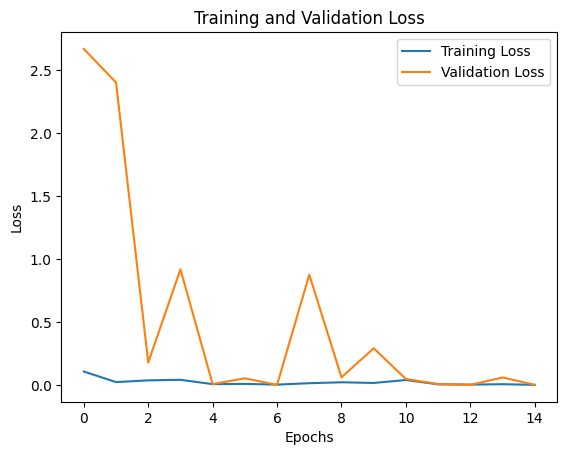

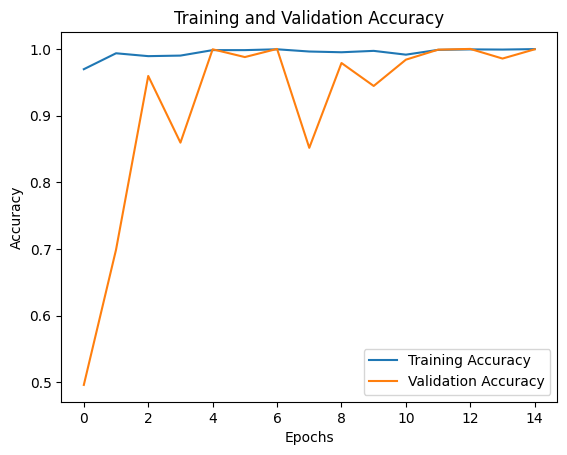

In [12]:
import matplotlib.pyplot as plt

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
